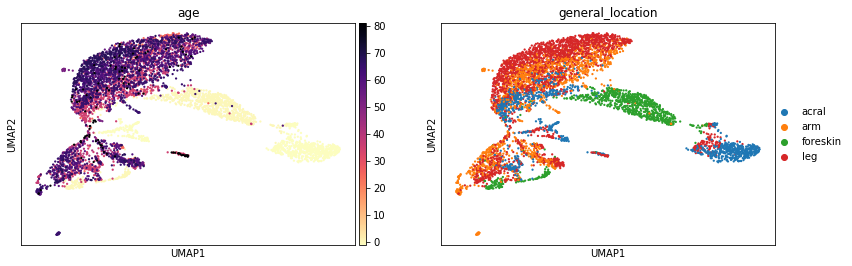

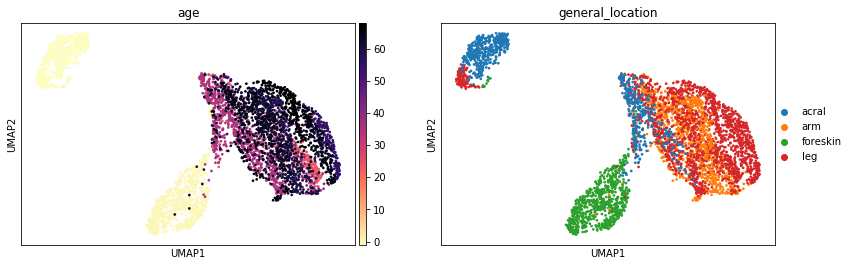

Completed


In [156]:
###############################################
###############################################
# Setup
# This chuck ingests pre-computed variables
###############################################
###############################################

# [Shift + Return] to run chunks 

###############################################

# settings
wkdir, s3dir = '/home/ubuntu/data/DL20181011_melanocyte_test_data', 'daniel.le-work/MEL_project'

%reload_ext autoreload
%autoreload 2
from scanpy_helpers import *
warnings.filterwarnings('ignore')
%matplotlib inline

# import data from s3
for file in ['adata_subset1', 'adata_subset2', 'full_adata', 'pre_adata','adata_subset1_KRT']:
#     ! aws s3 cp s3://{s3dir}/{file}.p {wkdir}/
    var = pickle.load((open(f'{wkdir}/{file}.p', 'rb')))
    exec(f'{file} = var')
    del var

# drop patients due to low cell count
adata_subset2_filtered = adata_subset2[[x not in ['A1015LM',
                                                'A1017LM',
                                                'A1012M'] for x in adata_subset2.obs.patient.tolist()]] 

# plot full data
sc.pl.umap(full_adata, color=['age','general_location'], cmap = 'magma_r')
sc.pl.umap(adata_subset2_filtered, color=['age','general_location'], cmap = 'magma_r')

print('Completed')


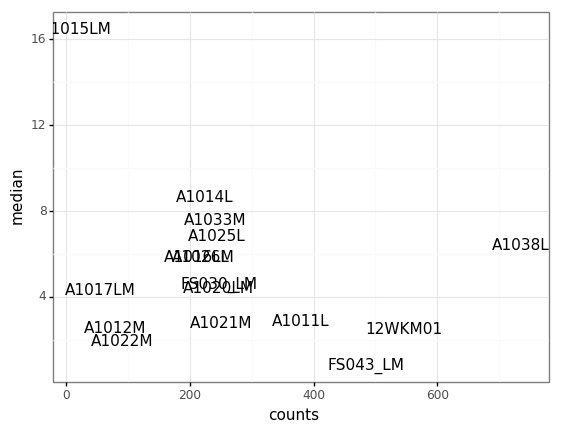

<ggplot: (-9223363265430307142)>
       median  counts  patient
11  16.463913      16  A1015LM
6    4.321738      56  A1017LM
1    2.512206      79   A1012M
7    1.908789      91   A1022M
15   5.829296     215  A1016LM


In [2]:
# Determine correlation between cell-wise txn noise and cell counts
input_adata = adata_subset2
med_list = []
count_list = []
patient_list = []
for x in set(input_adata.obs.patient):
    df_slice = input_adata.obs.filter(regex=x).dropna()
    count_list.append(len(df_slice))
    med_list.append(df_slice.iloc[:,0].median())
    patient_list.append(x)

plot_df = pd.DataFrame({'median':med_list,
                        'counts':count_list,
                        'patient':patient_list})

print(ggplot(plot_df, aes('counts','median',label='patient'))
      +theme_bw()   
      +geom_text())

print(plot_df.sort_values('counts').head())


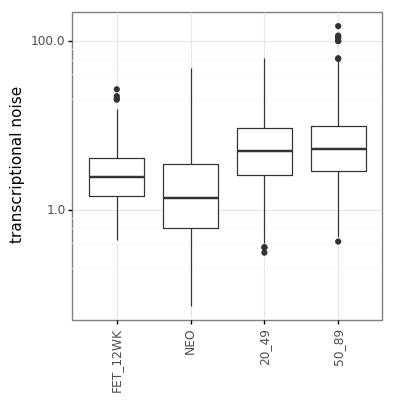

<ggplot: (-9223363265473878724)>
H-test:  796.7796552741293 p-value 2.160973446020021e-172


In [124]:
# cell-wise transcription noise vs grouping
input_adata = adata_subset2_filtered
groupby = 'age_group'
plot_df = (input_adata
           .obs
           .loc[:, [f'{x}' for x in input_adata.obs.columns if x.startswith('noise')] + [groupby]])
plot_df = pd.melt(plot_df, id_vars=groupby)

# plot
plotnine.options.figure_size=(4,4)
print(ggplot(plot_df)
         +theme_bw()
         +theme(axis_text_x=element_text(angle=90))
         +geom_boxplot(aes(groupby,'value'))
         +labs(y='transcriptional noise',x='')
         +scale_y_log10())

# Compute the Kruskal-Wallis H-test for independent samples
groups_dict = {}
for group in list(set(plot_df[groupby])):
    group_vec = plot_df[plot_df[groupby] == group]['value'].dropna().tolist()
    groups_dict[group] = group_vec

eval_list = [f'groups_dict["{i}"]' for i in groups_dict.keys()]
eval_subcmd = ','.join(eval_list)
eval_cmd = f'stats.kruskal({eval_subcmd})'
hstat, pval = eval(eval_cmd)
print('H-test: ', hstat, 'p-value', pval)


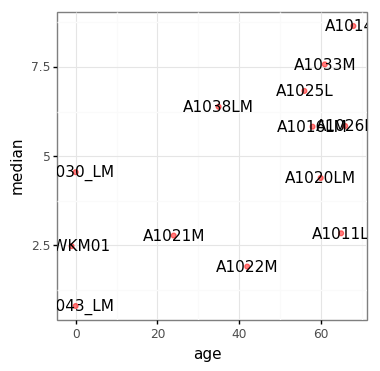

<ggplot: (-9223363265433958375)>
R2:  0.37330216175284897 p-value 0.026530433362018258


In [4]:
# plot age vs median txn noise
input_adata = adata_subset2_filtered
med_list = []
age_list = []
patient_list = []
for x in set(input_adata.obs.patient):
    df_slice = input_adata.obs.filter(regex=x).dropna()
    age_list.append(input_adata.obs[input_adata.obs.patient == x].age.values[0])
    med_list.append(df_slice.iloc[:,0].median())
    patient_list.append(x)

plot_df = pd.DataFrame({'median':med_list,
                        'age':age_list,
                        'patient':patient_list})

print(ggplot(plot_df, aes('age','median'))
      +theme_bw()
      +geom_point(alpha = 0.5, color ='red')
      +geom_text(aes(label='patient')))

r,pval = pearsonr(plot_df.age.values.tolist(), 
         plot_df['median'].values.tolist())
print('R2: ', r**2, 'p-value', pval)


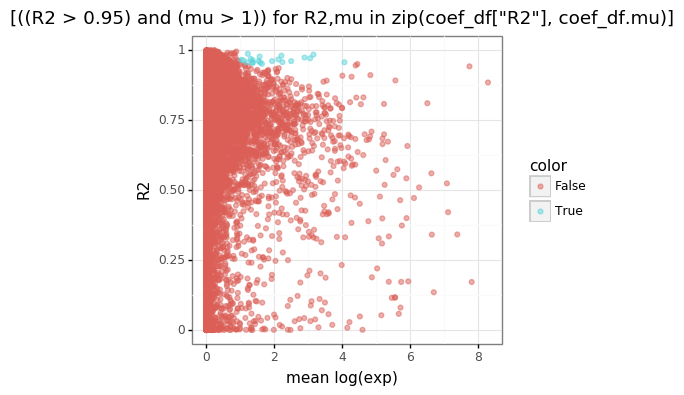

<ggplot: (-9223363265508409305)>
          gene         R      pval        mu        R2      1-R2  color
8319  SLC25A37  0.993230  0.006770  1.228888  0.986506  0.013494   True
6394       NOV  0.991725  0.008275  3.162110  0.983518  0.016482   True
7359    PRSS23 -0.989851  0.010149  2.219330  0.979806  0.020194   True
2652   FAM208A  0.988082  0.011918  1.577453  0.976306  0.023694   True
6246     NDRG2 -0.986394  0.013606  2.899423  0.972973  0.027027   True
3968       JUN  0.985112  0.014888  3.063512  0.970445  0.029555   True
3091     GCNT2  0.984100  0.015900  1.313282  0.968453  0.031547   True
3499     HIPK2  0.983002  0.016998  2.126900  0.966293  0.033707   True
5974      MPDZ  0.982308  0.017692  1.036662  0.964928  0.035072   True
2758    FBXO17  0.981492  0.018508  1.370244  0.963326  0.036674   True
3562     HLA-F -0.981258  0.018742  1.098423  0.962866  0.037134   True
9061     TEAD1  0.980203  0.019797  1.545086  0.960798  0.039202   True
1594   CLEC11A  0.980061  0.019

The protein encoded by this gene is a proton-linked monocarboxylate transporter that catalyzes the movement of many monocarboxylates, such as lactate and pyruvate, across the plasma membrane. Mutations in this gene are associated with erythrocyte lactate transporter defect. Alternatively spliced transcript variants have been found for this gene.[provided by RefSeq, Oct 2009].
19: SREK1
This gene encodes a member of a family of serine/arginine-rich (SR) splicing proteins containing RNA recognition motif (RRM) domains. The encoded protein interacts with other SR proteins to modulate splice site selection. Alternatively spliced transcript variants encoding multiple isoforms have been observed for this gene. [provided by RefSeq, Jul 2012].
20: C10orf32
N/A


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [151]:
# # calculate transcription noise per gene
groupby='age_group'
input_adata = adata_subset2_filtered

cat, df = prepare_dataframe(input_adata, 
                  var_names=input_adata.var_names,
                  groupby=groupby)

# coefficient of variation vs age bin
gene_std = df.groupby(groupby).std()
gene_mean = df.groupby(groupby).mean()
gene_coef = gene_std/gene_mean
gene_coef = gene_coef.reset_index()
gene_coef = (gene_coef
             .set_index(groupby)
             .sort_index())

# std vs age bin
# gene_std = df.groupby(groupby).std()
# gene_mean = df.groupby(groupby).mean()
# gene_coef = gene_std
# gene_coef = gene_coef.reset_index()
# gene_coef = (gene_coef
#              .set_index(groupby)
#              .sort_index())

# SNR vs age bin
# gene_std = df.groupby(groupby).std()
# gene_mean = df.groupby(groupby).mean()
# gene_coef = gene_mean/gene_std
# gene_coef = gene_coef.reset_index()
# gene_coef = (gene_coef
#              .set_index(groupby)
#              .sort_index())

r_list=[]
p_list=[]
mu_list=[]
for x in gene_coef.columns:
    r,p = pearsonr([x for x in range(gene_coef.shape[0])], 
                   gene_coef.loc[:, x])
    r_list.append(r)
    p_list.append(p)
    mu_list.append(df.loc[:,x].mean())
coef_df = pd.DataFrame({'gene':gene_coef.columns,
                         'R':r_list,
                         'pval':p_list,
                       'mu':mu_list})
coef_df['R2'] = coef_df['R']**2
coef_df['1-R2'] = 1-coef_df['R2']
condition_cmd = '[((R2 > 0.95) and (mu > 1)) for R2,mu in zip(coef_df["R2"], coef_df.mu)]'
condition_vec = eval(condition_cmd)
coef_df['color'] = condition_vec
coef_df = coef_df.sort_values('pval', ascending=True)
coef_df = coef_df.dropna()

# plot and print 
print(ggplot(coef_df)
      +theme_bw()
      +geom_point(aes('mu','R2', color = 'color'), alpha = 0.5)
      +ggtitle(condition_cmd)
      +labs(y = 'R2', x = 'mean log(exp)'))

print(coef_df[coef_df.color == True])

gene = coef_df[coef_df.color == True].gene
out = symbol2field(gene)
full_report = ['{}: {}\n{}'.format(idx,
                            x['query'],
                            x['summary']) if ('summary' in x.keys()) else '{}: {}\n{}'.format(idx,
                            x['query'],
                            'N/A') for idx, x in enumerate(out)]
output = search_term = ''
[print(x) for x in full_report if search_term in x]

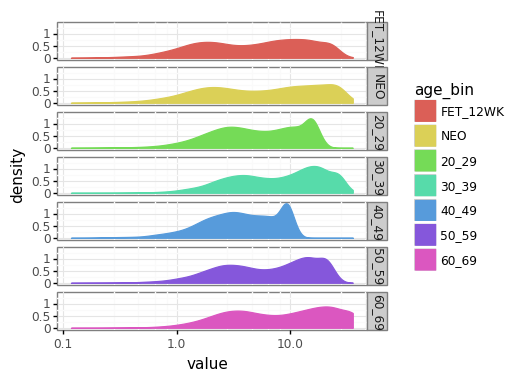

<ggplot: (-9223363265435021838)>


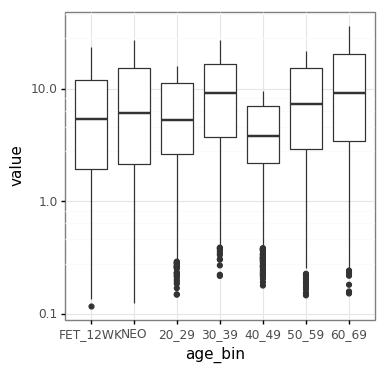

<ggplot: (8771379964971)>


In [127]:
# look at distribution of covar with respect to age bin ==> ridge plot like
plot_df = gene_coef.T.rename(columns=str).reset_index()
plot_df = pd.melt(plot_df, id_vars='index')
plot_df[groupby] = (plot_df[groupby]
                    .astype(str)
                    .astype(CategoricalDtype(gene_coef.reset_index()[groupby].cat.categories.tolist(), ordered=True)))

print(ggplot(plot_df, aes('value', fill=groupby,
                         color=groupby))
     + theme_bw()
     + geom_density()
     + scale_x_log10()
     + facet_grid(f'{groupby}~'))

print(ggplot(plot_df, aes(groupby, 'value'))
     + theme_bw()
     + scale_y_log10()
     + geom_boxplot())

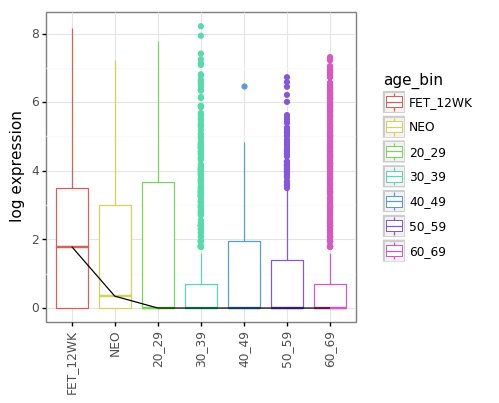

<ggplot: (8771380272013)>


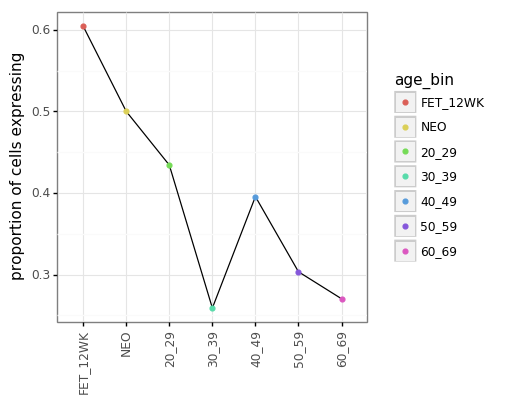

<ggplot: (8771386919421)>


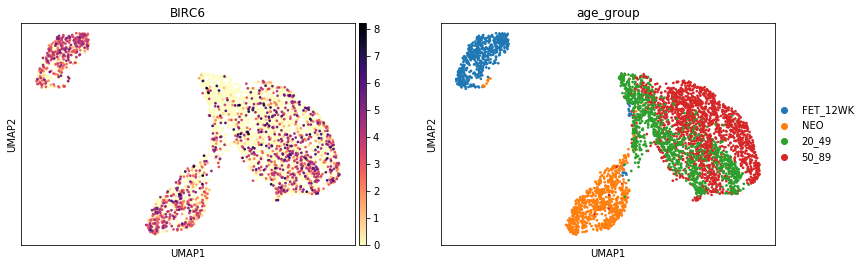

querying 1-1...done.
Finished.
0:  BIRC6 
 This gene encodes a protein with a BIR (baculoviral inhibition of apoptosis protein repeat) domain and a UBCc (ubiquitin-conjugating enzyme E2, catalytic) domain. This protein inhibits apoptosis by facilitating the degradation of apoptotic proteins by ubiquitination. [provided by RefSeq, Jul 2008].


[None]

In [155]:
# plot expression
gene = 'BIRC6'
input_adata = adata_subset2_filtered
groupby='age_bin'

gene2plots(input_adata, gene, groupby)
sc.pl.umap(input_adata, color=[gene, 'age_group'], cmap='magma_r')
out = symbol2field(gene)
[print(f'{idx}: ', 
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]

# Dev

In [5]:
input_adata = adata_subset2_filtered
groupby = ['age', 'age_bin', 'age_group']

# cell and gene ids from filtered adata obj
cell_names = input_adata.obs_names.tolist()
gene_names = input_adata.var_names.tolist() + [x for x in pre_adata.index.tolist() if x.startswith('ERCC-')]

# filter raw data
pre_adata_processed = pre_adata.reset_index()
pre_adata_processed = pre_adata_processed[[x in gene_names for x in pre_adata_processed.gene_name]]
pre_adata_processed = pre_adata_processed.loc[:,cell_names]

# process table
pre_adata_T = pre_adata_processed.T
pre_adata_T.columns = gene_names
pre_adata_T = (pre_adata_T
               .reset_index()
               .rename(columns = {'index':'cell_name'}))
pre_adata_T = pd.merge((input_adata
                        .obs
                        .loc[:,groupby]
                        .reset_index()
                        .rename(columns = {'index':'cell_name'})),
                       pre_adata_T,
                       'left',
                       'cell_name')



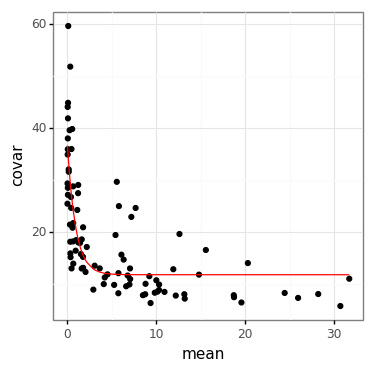

<ggplot: (-9223363265475564470)>


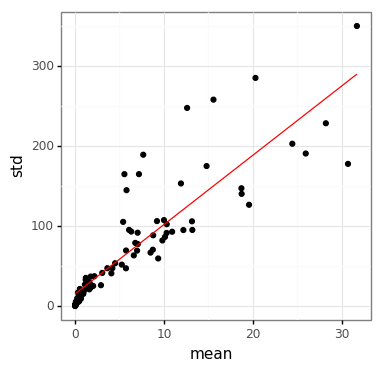

<ggplot: (-9223363265508279345)>


In [57]:
# get ERCC's only and plot covar vs mean
ercc_stats = pre_adata_T.filter(regex='ERCC-').describe().T
ercc_stats['covar'] = ercc_stats['std']/ercc_stats['mean']
ercc_stats['log_covar'] = np.log(ercc_stats['covar'])
ercc_stats = ercc_stats.reset_index()
ercc_stats['log10_std'] = np.log10(ercc_stats['std'])
ercc_stats['log10_mean'] = np.log10(ercc_stats['mean'])
ercc_stats['log10_covar'] = np.log10(ercc_stats['covar'])
ercc_stats = ercc_stats.sort_values('mean')

# fit exponential decay to covar
import scipy.optimize

def model_func(t, A, K, C):
    return A * np.exp(-K * t) + C
def fit_exp_nonlinear(t, y):
    opt_parms, parm_cov = scipy.optimize.curve_fit(model_func, t, y, maxfev=1000)
    A, K, C = opt_parms
    return A, K, C

A, K, C = fit_exp_nonlinear(ercc_stats['mean'].values, ercc_stats['covar'].values)
fit_y = model_func(ercc_stats['mean'].values, A, K, C)
ercc_stats['nl_fit'] = fit_y

# fit line to std    
def f(x, A, B): # this is your 'straight line' y=f(x)
    return A*x + B

A,B = scipy.optimize.curve_fit(f, ercc_stats['mean'].values, ercc_stats['std'].values)[0] # your data x, y to fit
fit_y_line = f(ercc_stats['mean'].values, A, B)
ercc_stats['l_fit'] = fit_y_line

print(ggplot(ercc_stats)
      +theme_bw()
      +geom_point(aes('mean','covar'))
      +geom_line(aes('mean', 'nl_fit'), color = 'red'))

print(ggplot(ercc_stats)
      +theme_bw()
      +geom_point(aes('mean','std'))
      +geom_line(aes('mean', 'l_fit'), color = 'red'))


In [142]:
# all_genes_table = pre_adata_T.describe().T
all_genes_table['covar'] = all_genes_table['std']/all_genes_table['mean']
all_genes_table['ercc'] = [x.startswith('ERCC-') for x in all_genes_table.index]

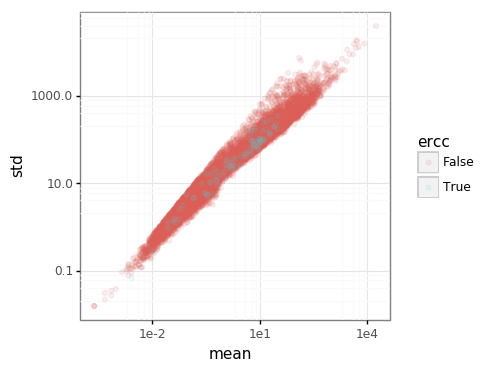

<ggplot: (8771380752753)>


In [148]:
print(ggplot(all_genes_table.iloc[1:,:])
     +theme_bw()
     +geom_point(aes('mean', 'std', color = 'ercc'), alpha=0.1)
     +scale_x_log10()
     +scale_y_log10())